# Cluster analysis using unsupervised machine learning techniques with the current dataset? For example, find clusters with the help of the k-means algorithm

In [2]:
# import required lib
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import calendar 
from sklearn.cluster import KMeans
import warnings
from sklearn.cluster import MeanShift,estimate_bandwidth
import numpy as np
from itertools import cycle
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
warnings.filterwarnings("ignore")

# Load data from all the sources

In [3]:
#Read the data
orders_all = pd.read_csv("perf_test_orderdata/orders_all.csv")
orders_times = pd.read_csv("perf_test_orderdata/orders_times.csv")

In [4]:
#join the column to connect the two csv data
merge = pd.merge(orders_all,orders_times,how='left',on='admin_reference')

# Prepare Data

In [5]:
#drop the features which has most null values
orders = merge.drop(['completed_at_x','customer_company','bill_state_name','ship_state_name','ship_company','subsite_store','campaign_code','bill_company'],axis=1)

In [6]:
#for campaign 
campaign_code = merge.drop(['completed_at_x','customer_company','bill_state_name','ship_state_name','ship_company','subsite_store','bill_company'],axis=1)

In [7]:
#prepasre the dat 
def prep_data(data):
    #Date and time is splitted
    new = data["completed_at_y"].str.split(" ", n = 1, expand = True) 
    data['Date'] = new[0]
    data['Time'] = new[1]
    #Day, month and year is splitted
    new = data["Date"].str.split("-", n = 2, expand = True) 
    data['Year'] = new[0]
    data['Month'] = new[1]
    data['Day'] = new[2]
    #drop null values
    data = data.dropna()
    #convert month number to month name
    data['Month'] = data['Month'].astype(int).apply(lambda x: calendar.month_abbr[x])
    #Date and time is splitted
    new = data["Time"].str.split(":", n = 1, expand = True) 
    data['Hour'] = new[0]
    data['Minute'] = new[1]

    data['Date'] = pd.to_datetime(data['Date'])  # Step 1
    data['DayofWeek'] =data['Date'].dt.day_name()  # Step 2
    return data

In [8]:
orders = prep_data(orders)
campaign_code = prep_data(campaign_code)

In [9]:
orders = orders.drop([ 'state', 'shipment_state',
       'currency', 'bill_zipcode',
       'ship_city', 'ship_zipcode', 'ship_country_iso_name'],axis=1)

## Using Elbow method find K (Clusters)

In [10]:
k_range = range(1,10)
sse = []
X = orders[['total','quantity']]

In [11]:
#loop rnage of k values to find the SSE!
for k in k_range:
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    sse.append(km.inertia_)

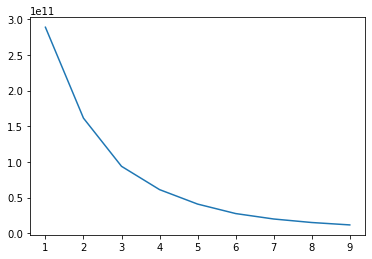

In [12]:
plt.plot(k_range,sse)
plt.show()

### Apply KMeans clustering algorithm using the K value

In [13]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
predict = kmeans.predict(X)
print(predict)

[0 0 0 ... 2 2 2]


In [14]:
#Center values of cluster
kmeans.cluster_centers_

array([[3.79473569e+02, 1.36078167e+00],
       [1.27843120e+04, 3.28785358e+00],
       [3.68905868e+03, 1.83895744e+00],
       [1.22268066e+03, 1.48548297e+00]])

In [15]:
#adding cluster to the dataset
X['cluster'] = predict

In [16]:
X.cluster.unique()

array([0, 3, 1, 2], dtype=int32)

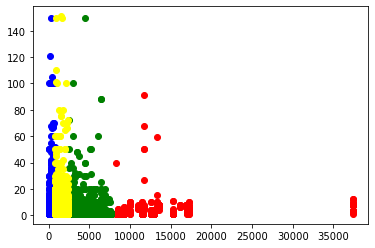

In [17]:
df1 = X[X['cluster'] == 0]
df2 = X[X['cluster'] == 1] 
df3 = X[X['cluster'] == 2]
df4 = X[X['cluster'] == 3]

plt.scatter(df1.total,df1.quantity,color = 'blue')
plt.scatter(df2.total,df2.quantity,color = 'red')
plt.scatter(df3.total,df3.quantity,color = 'green')
plt.scatter(df4.total,df4.quantity,color = 'yellow')
plt.show()

## Means Shift Clustering

In [55]:
X = orders[['total','quantity']]

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth).fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

KeyboardInterrupt: 

In [ ]:
# Plot result
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## DBSCAN Clustering

In [ ]:
# Compute DBSCAN
X = orders[['total','quantity']]
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Agglomerative Hierarchical Clustering

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = orders[['total','quantity']]

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()